# Простейшие нейронные сети с Keras


Фрэймворком для обучения нейросеток на нашем курсе будет Tensorflow. Причин для этого очень много. Их мы обсудили на лекции. Недавно Google анонсировал вторую версию библиотеки. В апреле 2019 года закончилось тестирование альфа-версии (внутри компании) и [была выпущена](https://www.tensorflow.org/beta/guide/effective_tf2) бета-версия. В конце августа была подготовлена версия для релиза. Первая версия библиотеки продолжит поддерживаться, но со временем умрёт. 

Одна из особенностей новой версии заключается в том, что Keras (раньше он был посторонней библиотекой-надстройкой) фактически [стал частью tensorflow.](https://www.tensorflow.org/guide/keras?hl=ru)  

Изначально Keras создавался как высокоуровневое API для theano (это когда написали кучу функций один раз, красиво их назвали и завернули в пакет). Потом он начал поддерживать tensorflow, а сейчас вот чуть ли ни аннексия произошла. __Keras наш.__ Именно со знакомства с ним мы и начнём наше погружение в нейросетки.  

Чтобы установить библиотеку, отправляйтесь в консоль и пропишите 

```
pip install tensorflow==2.0.0-beta1 
```

Если вы до этого сидели на старой версии tensorflow, на всякий случай снесите её. Иначе при установке могут возникнуть какие-нибудь несовместимости и ошибки.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Подгружаем tensorflow 
import tensorflow as tf
import tensorflow.keras as keras
# keras = tensorflow.keras

print(tf.__version__)
print(keras.__version__) 

2.2.0
2.3.0-tf


In [3]:
# Подгрузим ещё немного пакетов :) 
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

## 1. О данных и бэйзлайнах

Наша главная цель - как следует потрогать Keras своими ручищами. Мы хотим увидеть, что он реально позволяет обращаться с нейронками как с конструктором LEGO и предлагает нам для сборки башен кучу деталей. 

__Делать всё это мы будем на животных.__ Ежегодно около 7.6 миллионов бедных животных в США оказываются в приютах. Часть из них находит себе новую семью, часть возвращается к старому (бывает, что питомец потерялся и его нашли на улице), а часть погибает. Ужегодно усыпляется около 2.7 млн. собак и кошек.  

Используя датасет с входной информацией (цвет, пол, возраст и т.п.) из одного из приютов, мы попытаемся спрогнозировать что произойдёт с новыми животными, которые попадут в этот приют. Данные, используемые в тетрадке уже были предварительно обработаны и приведены в удобную для построения моделей форму. 

In [4]:
X = pd.read_csv('X_cat.csv', sep = '\t', index_col=0)
target = pd.read_csv('y_cat.csv', sep = '\t', index_col=0, names=['status'])

print(X.shape)
X.head()

(26729, 37)


,IsDog,Age,HasName,NameLength,NameFreq,MixColor,ColorFreqAsIs,ColorFreqBase,TabbyColor,MixBreed,...,SexStatus_Flawed,SexStatus_Intact,SexStatus_Unknown,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,1,365.0,1,7,0.000157,1,0.032919,0.463624,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,365.0,1,5,0.000655,0,0.008092,0.015005,1,1,...,1,0,0,0,0,0,0,0,0,1
2,1,730.0,1,6,0.000052,1,0.026293,0.357521,0,1,...,1,0,0,0,0,0,0,0,1,0
3,0,21.0,0,7,0.285871,0,0.000471,0.058418,0,1,...,0,1,0,0,0,0,0,1,0,0
4,1,730.0,0,7,0.285871,0,0.023831,0.075353,0,0,...,1,0,0,0,0,0,0,1,0,0


В датасете находится около 27 тысяч наблюдений и 39 регрессоров. Посмотрим на то как выглядит распределение того, что произошло со зверятами по особям.

In [5]:
target.status.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: status, dtype: int64

Видим, что классы несбалансированы. Попробуем оставит четыре класса и объединить класс умерших животных с классом животных, которых усыпили. 

In [6]:
target = target.values
target[target == 'Died'] = 'Euthanasia'

Закодируем классы.

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(target)
y

array([2, 1, 0, ..., 0, 3, 3])

In [8]:
len(y)

26729

In [9]:
X.shape

(26729, 37)

Разобьём выборку на тренировочную и тестовую. 

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 42)

print(X_train.shape)
print(X_test.shape)

(21383, 37)
(5346, 37)


Прежде, чем учить 228-слойных монстров, давайте построим какие-нибудь простые прогнозы, чтобы было с чем сравнить. Давайте построи наивный прогноз, а также обучим линейную регрессию и случайный лес.

### Константный прогноз

Построим константный прогноз, чтобы было с чем сравнивать и прогноз по какой-нибудь модели. 

In [11]:
from sklearn.metrics import log_loss

probas = np.array(pd.Series(y_train).value_counts(normalize=True).sort_index().tolist())
probas

array([0.40289015, 0.0655661 , 0.17906748, 0.35247627])

In [12]:
log_loss(y_test, np.tile(probas, X_test.shape[0]).reshape(X_test.shape[0], 4))

1.2202552496487795

### Логистическая регрессия

In [13]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression( )
logreg.fit(X_train, y_train)
log_loss(y_test, logreg.predict_proba(X_test))

1.0690613898794636

In [14]:
logreg.predict_proba(X_test) # 4 колонки, по одной на каждый класс

array([[0.18708144, 0.06705943, 0.04653878, 0.69932035],
       [0.71547747, 0.02923719, 0.10843419, 0.14685114],
       [0.52377723, 0.03810258, 0.18067791, 0.25744228],
       ...,
       [0.77510791, 0.01025085, 0.17601274, 0.0386285 ],
       [0.22847277, 0.05774782, 0.03826853, 0.67551088],
       [0.66540038, 0.03012528, 0.12082905, 0.18364529]])

### Случайный лес 

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, n_jobs=3)
rf.fit(X_train, y_train)
log_loss(y_test, rf.predict_proba(X_test))

0.7626981043511731

Неплохой результат. Попробуем улучшить его с помошью нейросеток. 

## 2. Собираем свою нейросеть

In [16]:
from tensorflow.keras import layers as L         # Уже готовые слои для моделей
from tensorflow.keras.models import Sequential   # Специальный класс для склеивания слоёв
from tensorflow.keras.models import Model        # Альтернативный класс для склейки слоёв
import tensorflow.keras.optimizers as opt        # Разные оптимизационные алгоритмы :3 

Модель в Keras собирается как конструктор LEGO. Её можно описать двумя основными способами. Первый — последовательное описание модели. В его случае мы как бы создаём коробочку `model` и постепенно добавляем туда детальки нашей сетки. 

Второй способ - описать модель функционально, в явном виде прописав какие аргументы идут на вход какому слою. 

Элемент b наследуется от элемента a:

В sequential строим сеть последовательно, в Model можем возвращаться к каким-то слоям по мере построения модели, главное, чтобы из входы можно было получить выход - Model(inputs=a, outputs=b) и не было циклов в графе

В нейронках есть следующие гиперпараметры: количестов слоев, количество нейронов, функция активации. Для начала этого достаточно

Когда мы будем строить сложные модели с кучей разветвлений, для нас будет удобным второй способ. Для простых ситуаций вроде текущей, можете пользоваться первым. 

Давайте соберём небольшую нейронку. Давайте сделаем в ней вот такую архитектуру: 

In [17]:
def get_new_model( ):

    ###########################################################
    # Ваш код! 
    model = Sequential(name = 'Archibald')  # модели можно дать имя!
    
    # Добавляем в нашу модель первый слой из 25 нейронов
    # входная резмерность - количество фичей
    # начальные веса семплируем из случайного нормального распределения
    # функция активации можно прописать прямо сюда:
    # model.add(L.Dense(25, activation='sigmoid , input_dim = X_train.shape[1], kernel_initializer='random_normal'))
    model.add(L.Dense(25, input_dim = X_train.shape[1], kernel_initializer='random_normal'))

    # Добавляем функцию активации на первый слой 
    model.add(L.Activation('sigmoid'))

    # Добавляем ещё один слой из 25 нейронов
    # не прописываем входную размерность, тк керас сам берет данные из предыдущего слоя
    model.add(L.Dense(25, kernel_initializer='random_normal'))
    model.add(L.Activation('sigmoid'))

    # На выходе мы должны получить вероятности того, что объект относится к разным классам 
    # Сделать такое преобразование позволяет softmax как функция активации
    # На выход будет идти 4 вероятности по числу классов
    model.add(L.Dense(4, activation='softmax', kernel_initializer = 'random_normal'))
    
    ###########################################################
    
    # В качестве оптимизации будем использовать Adam
    # Это такой специальный градиентный спуск, обсудим его в следущий раз
    optimizer = opt.Adam(lr=1e-3)

    # Собираем модель
    model.compile(loss = 'categorical_crossentropy', 
                  metrics=["accuracy"], 
                  optimizer=optimizer)
    
    return model

Перед тем как обучать нашу нейросеть, нужно задать параметры обучения. Во-первых, метод оптимизации. Во-вторых, функцию потерь. В-третьих, парочку метрик, на которые нам хотелось бы смотреть в процессе обучения.  Для этого есть метод `compile`. 

In [18]:
model = get_new_model( )

Итак, только что мы собрали свою первую нейросеть со скрытым слоем.   Посмотрим сколько параметров нам предстоит оценить. 

In [19]:
model.summary()

Model: "Archibald"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                950       
_________________________________________________________________
activation (Activation)      (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                650       
_________________________________________________________________
activation_1 (Activation)    (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 104       
Total params: 1,704
Trainable params: 1,704
Non-trainable params: 0
_________________________________________________________________


Видим, что нужно оценить огромное количество параметров. На оценку каждого параметра придётся совсем маленькое количество наблюдений. 

In [20]:
X_train.shape[0]/1704

12.548708920187794

Отлично! Модель собрана. Осталось её обучить. Метод `fit` позволяет сделать это. Он принимает на вход обучающую выборку `X_train, y_train`. Параметр  `batch_size` это  размер батча. Этот параметр ограничивает количество примеров, которое за раз подаётся в нашу нейронную сеть. Количиство эпох для обучения, `epochs` - это число проходов модели по обучающей выборке. 

Обычно нейросетки обучаются довольно долго. В связи с этим обучать их на различных фолдах и оценивать качество работы модели на кросс-валидации не очень быстрое занятие, которое себе может позволить далеко не каждый. Для проверки качества обычно внутри обучения с помощью параметра `validation_split` часть выборки оставляют под валидацию, которая осуществляется после каждой эпохи. Как только качество на валидации начнёт падать, это будет означать, что модель переобучилаcь. 

Всё, что будет нам возвращать метод `.fit`, мы запишем в переменную `hist`. После обученя модели там окажется вся история ошибок на каждом шаге обучения. Отключить сообщения о том, на каком этапе обучения в данный момент находится модель, можно с параметром `verbose = 0`. Переменную $y$ для успешного обучения сетки нужно будет перевести в матрицу из дамми-переменных с помощью команды `to_categorical`. 

In [21]:
from keras.utils import to_categorical
to_categorical(y)

Using TensorFlow backend.


array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [22]:
%%time
# Попробуйте переключить verbose = 1 и будет чудо!
# validation split - каккую часть от трейна мы отщипываем для валидации сетки
# epoch - сколько раз мы пройдемся по всему датасету
hist = model.fit(X_train, to_categorical(y_train), validation_split=0.2, epochs=100, verbose=0)

CPU times: user 1min 9s, sys: 20.8 s, total: 1min 30s
Wall time: 41 s


Возвращает этот метод history — это история ошибок на каждом шаге обучения. Посмотрим на динамику ошибок нашей модели во времени. 

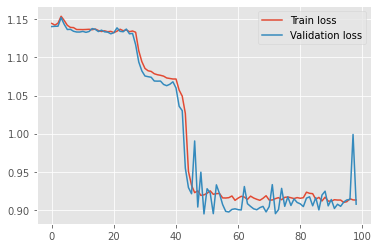

In [23]:
# модель плохо учится, переобучения нет, тк train loss и validation loss расходятся не сильно
start = 1
plt.plot(hist.history['loss'][start:])
plt.plot(hist.history['val_loss'][start:])
plt.legend(['Train loss', 'Validation loss'])

In [24]:
# Можно предсказать вероятности для тестовой выборки
model.predict_proba(X_test)

Instructions for updating:
Please use `model.predict()` instead.


array([[0.86827976, 0.00289516, 0.02044034, 0.10838471],
       [0.5617475 , 0.01624782, 0.18403143, 0.23797329],
       [0.07464445, 0.09058511, 0.02251118, 0.8122593 ],
       ...,
       [0.56175566, 0.01624728, 0.18402867, 0.23796839],
       [0.8630153 , 0.00307345, 0.02095249, 0.11295876],
       [0.8687108 , 0.00288072, 0.02039792, 0.10801055]], dtype=float32)

In [25]:
# А можно классы 
model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([0, 0, 3, ..., 0, 0, 0])

In [26]:
# Можно найти logloss 
log_loss(y_test,model.predict_proba(X_test))

0.9270287420317737

In [27]:
# Можно сохранить модель
model.save("weights.h5")

In [28]:
# Можно посмотреть на качество модели по всем указанным при коммпиляции метрикам. 
score = model.evaluate(X_test, to_categorical(y_test), verbose=0)
# считаем logloss и accuracy
score 

[0.9270287156105042, 0.619528591632843]

Модель сходится довольно плохо. Функция потерь на валидации со временем начинает скакать. __Как думаете, с чем это связано?__

----------------------------------

__Ответ:__ Вспомним про такую замечательную штуку как нормальзация и посмотрим насколько она улучшит скорость обучения и качество модели.

In [29]:
# всегда обрабатываем данные перед нейронками
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Обучаем модель на нормализованных данных. Попробуем учить подольше. Так сказать: двойной удар по сходимости. 

In [30]:
%%time
model = get_new_model( )  # Эпох стало 300 вместо 100
hist = model.fit(X_train, to_categorical(y_train), validation_split=0.2, epochs=300, verbose=0)

CPU times: user 3min 20s, sys: 1min 1s, total: 4min 22s
Wall time: 1min 55s


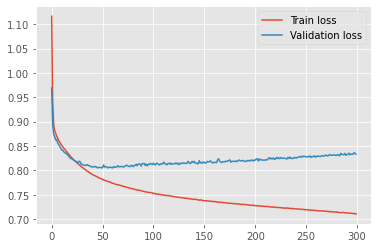

In [31]:
start = 0
plt.plot(hist.history['loss'][start:])
plt.plot(hist.history['val_loss'][start:])
plt.legend(['Train loss', 'Validation loss'])

In [32]:
score = model.evaluate(X_test, to_categorical(y_test), verbose=0)
score 

[0.8386081457138062, 0.6599326729774475]

Качество нашей модели на валидационных данных достигает пика после определенного количества эпох, а затем начинает снижаться. Это происходит из-за того, что модель начинает __переобучаться.__ Очень важно знать способы как можно предотвратить это. Переобученая модель просто запоминает выборку. Нам бы хотелось, чтобы она обобщала закономерности и адекватно вела себа на новых данных.

Обратным случаем переобучения является __недообучение.__ Оно возникает, когда все еще есть возможность улучшить показатели модели на проверочном наборе данных. Недообучение может произойти по разным причинам: например, если модель недостаточно сильная, или слишком сложная, или просто недостаточно тренировалась на данных. В любом случае это будет означать, что не были выучены основные паттерны из проверочного сета. Нам нужно найти золотую середину.

Чтобы избежать переобучения, наиболее оптимальным решением будет использовать больше тренировочных данных. Модели, обученные на большем количестве данных, естественным образом обобщают их лучше. Если возможность раздобыть ещё данных исчерпана, можно использовать методы регуляризации. Они ограничивают количество и тип инофрмации, которые модель может хранить в себе. Если нейросеть может запомнить только небольшое количество паттернов, то тогда процесс оптимизации заставит ее сфокусироваться на самых важных, наиболее заметных шаблонах, которые будут иметь более высокий шанс обобщения. __Попробуем дать переобучению бой!__

## 3. Бои с переобучением

Существует несколько способов регуляризации нейронных сетей. 

* EarlyStopping
* $l_1$ и $l_2$ регуляризация 
* Dropout

Попробуем всего по немногу. 

### 3.1 Early stopping

Одни сети сходятся за 5 эпох, другие не сходятся и за тысячу. Тренировать сетку в течение 1000 эпох, если она сходится за 5 - это не очень хорошая идея, так как качество на валидации начнёт падать и модель переобучится. Давайте попробуем останавливать обучение модели, как только оценка качества модели на валидации падает в течение нескольких эпох.

In [34]:
# Подгружаем раннюю остановку
# то, что будет подгружаться после каждой эпохи
from tensorflow.keras.callbacks import EarlyStopping

# Прикажем модели останавливать обучение, когда качество на валидации не будет улучшаться в течение 10 эпох
# Параметр patience определяет количество эпох, которые можно пропустить без улучшений
early_stopping_monitor = EarlyStopping(patience = 10)

model = get_new_model( ) # Сбросим старые веса 

# Функция для контроля остановки добавляется в параметр callbacks
hist_baseline = model.fit(X_train, to_categorical(y_train), validation_split=0.2, epochs=1000, 
                  verbose=0, callbacks = [early_stopping_monitor])

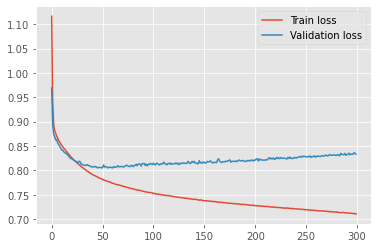

In [35]:
start = 0
plt.plot(hist.history['loss'][start:])
plt.plot(hist.history['val_loss'][start:])
plt.legend(['Train loss', 'Validation loss'])

In [36]:
score = model.evaluate(X_test, to_categorical(y_test), verbose=0)
score 

[0.8133791089057922, 0.6634867191314697]

Немного подробнее поговорим про __колбэки,__ которые закидываются в метод `fit` отдельным аргументом. Колбэки - это специальные функции, которые выполняются в процессе обучения на каждой эпохе и что-то делают. Давайте напишем свой колбэк. 

Когда сетка учится $1000$ эпох, очень неудобно включать параметр `verbose=1`, та как выдача захламляет тетрадку. При этом, за прогрессом следить хочется. Давайте сделаем функцию, которая после каждой эпохи будет рисовать точку. Тогда мы сможем компактно следить за ходом обучения. 

__Немного сложностей.__ Свой колбэк нужно писать в виде класса. Он пишется на основе уже готового класса `Callback` из пакета keras. Внутри можно делать разные функции, сообщающие что нужно делать на разных этапах обучения.

Понятное дело, что можно писать любые другие вспомогательные функции. Шестёрка, упомянутая выше, задаёт основную функциональность. Напишем свой колбэк! 

In [37]:
from tensorflow.keras import callbacks

class PrintDot(callbacks.Callback):

    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print('')
        print('.', end='')

In [38]:
%%time
dot_printer = PrintDot( )  # задали экземпляр такого колбэка
model = get_new_model( )   # сбросим старые веса 

# Закидываем новый колбэк в список функций 
hist = model.fit(X_train, to_categorical(y_train), validation_split=0.2, epochs=1000, 
                  verbose=0, callbacks = [early_stopping_monitor, dot_printer])


.........................................................................CPU times: user 52.1 s, sys: 15.8 s, total: 1min 7s
Wall time: 30.6 s


Дальше мы будем обучать довольно много разных моделей. Сделаем удобную функцию, чтобы рисовать их кривые обучения на одной картинке рядышком. 

In [39]:
def plot_history(histories, key='loss', start=0):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch[start:], history.history['val_'+key][start:],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch[start:], history.history[key][start:], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([start, max(history.epoch)])
    pass

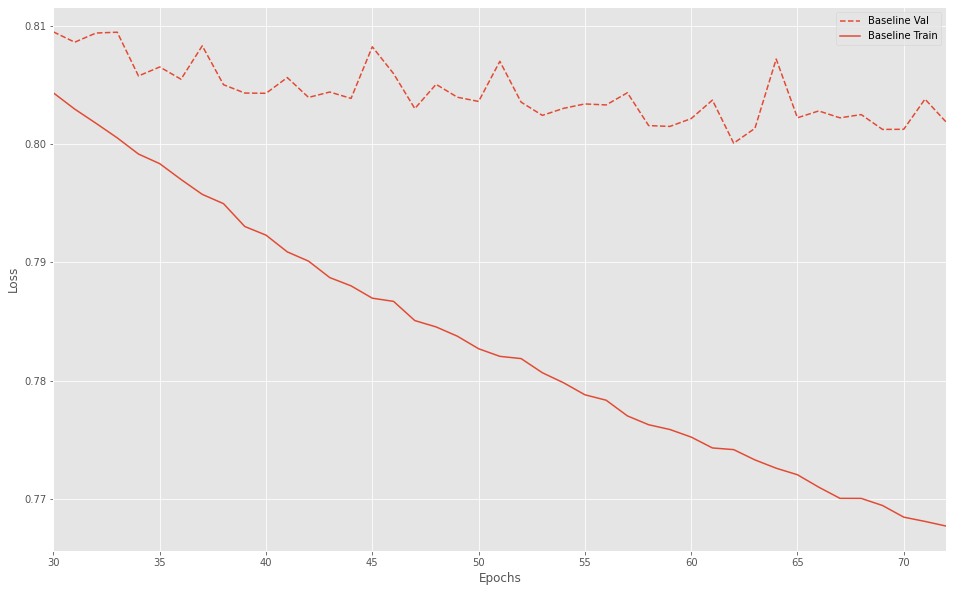

In [40]:
# Пример применения такой функции (через запятую можно перечислять имена моделей и их hist): 
plot_history([('baseline', hist), ],
             start=30 )

### 3.2  Dropout 

Метод ранней остановки позволял нам никак не видоизменять архитектуру нейросетки. Мы просто закидывали в процедуру, отвечающую за обучение, дополнительные характеристики. Но этого мало, Давайте попробуем поменять архитекутуру нашей модели. Например, использовать новую модную штуку, придуманную в 2015 году с гордым именем Dropout. 

![](https://hsto.org/web/dd8/171/16f/dd817116fc2348e78272577153e31d2d.jpeg)



In [42]:
model_dropout = Sequential( )

# Первый слой 
model_dropout.add(L.Dense(25, input_dim = X_train.shape[1], kernel_initializer='random_normal'))
model_dropout.add(L.Dropout(0.5)) # слой дропаута
model_dropout.add(L.Activation('sigmoid'))

# Второй слой 
model_dropout.add(L.Dense(25, kernel_initializer='random_normal'))
3
model_dropout.add(L.Activation('sigmoid'))


# Выходной слой 
model_dropout.add(L.Dense(4, activation='softmax', kernel_initializer = 'random_normal'))

# Собираем модель 
model_dropout.compile(loss = 'categorical_crossentropy', metrics=["accuracy"], optimizer=opt.Adam(lr=1e-3))

In [43]:
hist_dp_1 = model_dropout.fit(X_train, to_categorical(y_train), 
                         validation_split=0.2, epochs=100, verbose=0, callbacks = [PrintDot( )])


....................................................................................................

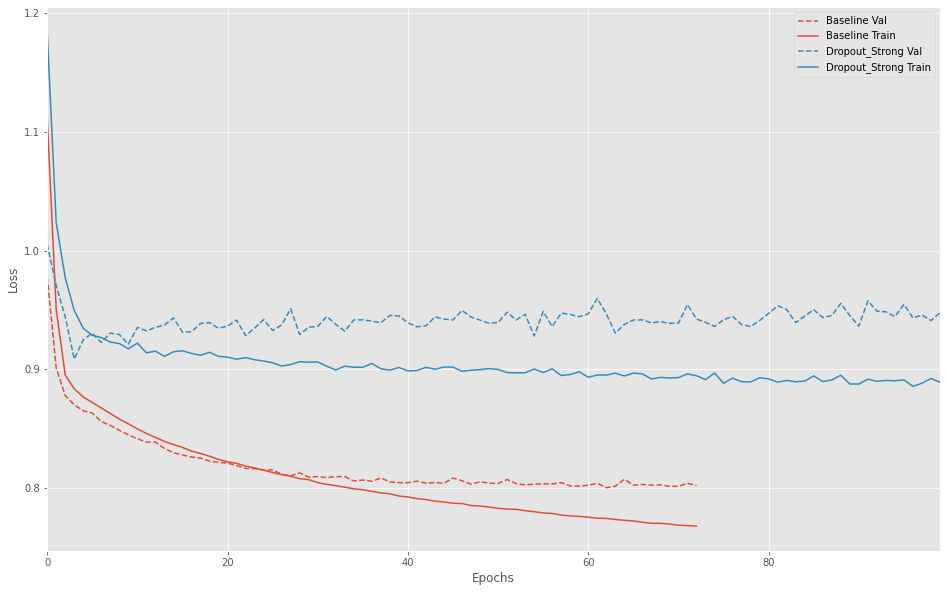

In [44]:
plot_history([('baseline', hist),
              ('dropout_strong', hist_dp_1)
             ],
             start=0)

На такой картинке явно видно второй порок-"недообучение". Попробуем уменьшить вероятность дропаута.

In [45]:
model_dropout = Sequential( )

# Первый слой 
model_dropout.add(L.Dense(25, input_dim = X_train.shape[1], kernel_initializer='random_normal'))
model_dropout.add(L.Dropout(0.2)) # слой дропаута уменьшаем вероятность до 0.2
model_dropout.add(L.Activation('sigmoid'))

# Второй слой 
model_dropout.add(L.Dense(25, kernel_initializer='random_normal'))
model_dropout.add(L.Dropout(0.2)) # тоже уменьшаем вероятность "выключения" нейроннов.
model_dropout.add(L.Activation('sigmoid'))


# Выходной слой 
model_dropout.add(L.Dense(4, activation='softmax', kernel_initializer = 'random_normal'))

# Собираем модель 
model_dropout.compile(loss = 'categorical_crossentropy', metrics=["accuracy"], optimizer=opt.Adam(lr=1e-3))

In [46]:
hist_dp_2 = model_dropout.fit(X_train, to_categorical(y_train), 
                         validation_split=0.2, epochs=100, verbose=0, callbacks = [PrintDot( )])


....................................................................................................

Droput weak работает лучше всего:

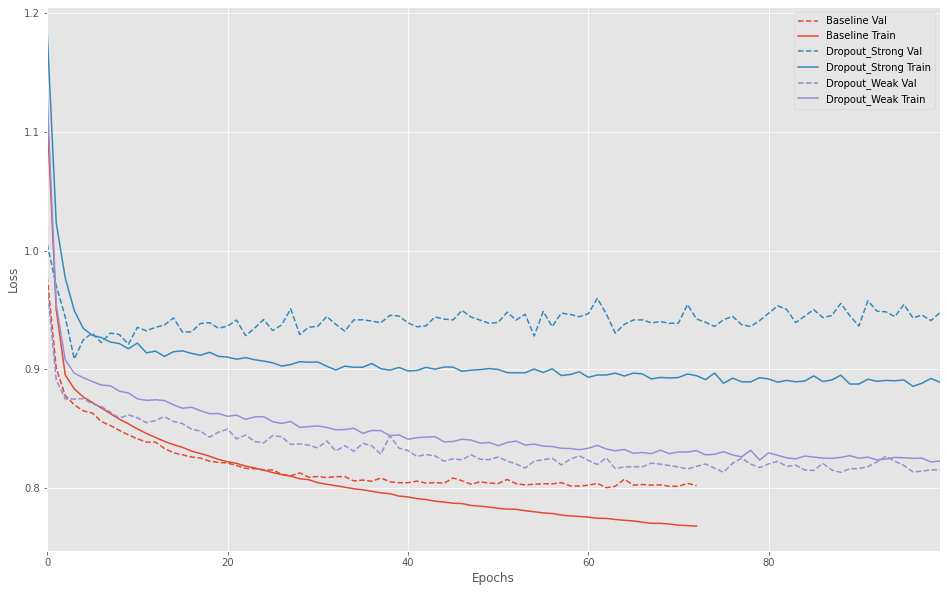

In [47]:
plot_history([('baseline', hist),
              ('dropout_strong', hist_dp_1),
              ('dropout_weak', hist_dp_2)
             ],
             start=0)

In [48]:
score = model_dropout.evaluate(X_test, to_categorical(y_test), verbose=0)
score 

[0.8366356492042542, 0.6601197123527527]

### 3.3 Регуляризация

Теперь добавим к нашей модели штраф на веса. Уменьшив коэффициенты модели, мы её упростим. Тем самым мы предотвратим переобучение.  В keras можно добавить для каждого слоя на три вида связей: 
	
* kernel\_regulirizer - на матрицу весов слоя;
* bias\_regulirizer - на вектор свободных членов;
* kernel\_regulirizer - на вектор выходов.





Значение `l2(0.01)` означает, что каждый коэффицент матрицы весов слоя будет добавлять `0.01 * weight_coefficient_value**2` к общей потери сети. Обрати внимание, что штраф добавляется только во время обучения, потери во время этой стадии будут гораздо выше, чем во время проверки.

In [49]:
from tensorflow.keras import regularizers
model_regulasition = Sequential( )

# Первый слой 
model_regulasition.add(L.Dense(25, input_dim = X_train.shape[1], kernel_initializer='random_normal',
                          kernel_regularizer=regularizers.l2(0.01)))

model_regulasition.add(L.Activation('sigmoid'))

# Второй слой 
model_regulasition.add(L.Dense(25, kernel_initializer='random_normal',
                              kernel_regularizer=regularizers.l2(0.01)))

model_regulasition.add(L.Activation('sigmoid'))


# Выходной слой 
model_regulasition.add(L.Dense(4, activation='softmax', kernel_initializer = 'random_normal'))

# Собираем модель 
model_regulasition.compile(loss = 'categorical_crossentropy', metrics=["accuracy"], optimizer=opt.Adam(lr=1e-3))

In [50]:
hist_reg = model_regulasition.fit(X_train, to_categorical(y_train), 
                         validation_split=0.2, epochs=200, verbose=0,callbacks = [PrintDot( )])


....................................................................................................
....................................................................................................

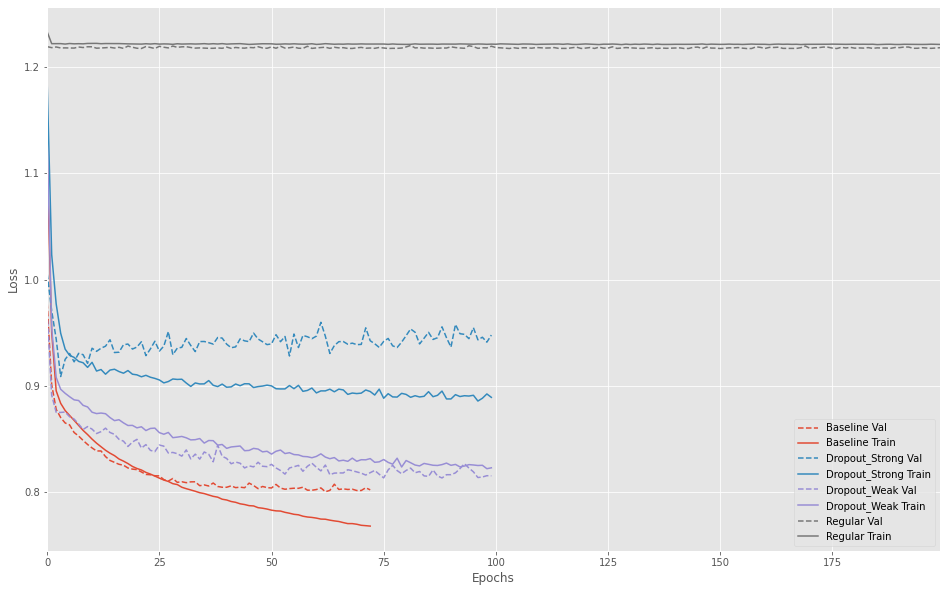

In [51]:
plot_history([('baseline', hist),
              ('dropout_strong', hist_dp_1),
              ('dropout_weak', hist_dp_2),
              ('regular', hist_reg)
             ],
             start=0)

## Различные воспитательные трюки 

1. Начните с маленькой сети. Не забывайте прикидывать сколько наблдюдений $n$ тратится на оценку каждого из $k$ параметров. Если величина $\frac{n}{k}$ очень маленькая, то не может идти речи об адекватных оценках параметров!  
2. Всегда оставляйте часть выборки под валидацию на каждой эпохе.
3. Усложняйте модель, пока качество на валидации не начнёт падать.
4. Не забывайте проскалировать ваши наблюдения для лучшей сходимости. 
5. Можно попробовать ещё целую серию различных **трюков**: 


* __Архитектура нейросети__
    * Больше/меньше нейронов
    * Больше/меньше слоёв 
    * Другие функции активации (tanh, relu, leaky relu, elu etc) 
    * Регуляризация (dropout, l1,l2) 


* __Более качественная оптимизация__  
    * Можно попробовать выбрать другой метод оптимизации 
    * Можно попробовать менять скорость обучения, моментум и др.
    * Разные начальные значения весов


* __Попробовать собрать больше данных__ 
* __Для случая картинок объёмы данных можно увеличить искусственно с помощью подхода, который называется Data augmemntation, но об этом позже__

И это далеко не полный список. Обратите внимание, что делать grid_search для больших сеток это довольно времязатратное занятие... 

## 4. Эксперименты 

Наверняка, у каждого в голове возникла какая-то классная идея по улучшению нашей базовой архитектуры. Пора реализовать её! Если идей нет, попробуйте: 

- Поменять функции активации на elu или сигмоиды
- Увеличить размер архитектуры 
- Увеличить или уменьшить вероятность дропауте

Не забывайте сохранять историю обучения и закидывать её на наш график для сравнения. Когда надоест, посмотрите на итоговое качество модели на тесте. А то по валидации и переобучиться можно :) 

In [ ]:
# Ваши эксперименты и код для них! 